In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings 
warnings.filterwarnings("ignore")


In [126]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [127]:
df.dropna(subset=["value_eur"], inplace=True)

In [128]:
# List of the columns you want to keep
columns_to_keep = [
    "player_positions", "overall", "potential", "value_eur", "wage_eur", "age", "height_cm", "weight_kg", 
    "club_team_id", "league_name", "league_level", "club_position", "club_joined", "club_contract_valid_until",
    "preferred_foot", "weak_foot", "skill_moves", "international_reputation", "work_rate", 
    "release_clause_eur", "pace", "shooting", "passing", "dribbling", "defending", "physic", "attacking_crossing", 
    "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", 
    "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", 
    "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", 
    "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", 
    "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", 
    "mentality_vision", "mentality_penalties", "mentality_composure", "defending_marking_awareness", 
    "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", 
    "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"
]

# Filter the DataFrame to keep only the specified columns
df_filtered = df[columns_to_keep]

# Check the result
df_filtered.head()


,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,ST,58,76,525000.0,952.712115,18,180,70,15005.0,Belgian Jupiler Pro League,...,43,13,19,17,7,6,8,10,7,NaN
1,"CM, CDM",55,75,350000.0,902.232819,19,179,68,1939.0,English League Championship,...,48,40,48,45,14,8,5,14,11,NaN
2,"CAM, CM",53,66,230000.0,2873.818374,21,180,65,12.0,English League Championship,...,52,26,23,31,14,8,13,9,6,NaN
3,GK,60,71,475000.0,678.608124,21,185,86,112115.0,Korean K League 1,...,26,8,14,12,60,60,54,63,61,23.0
4,CB,63,65,475000.0,1911.674228,28,185,70,631.0,Scottish Premiership,...,67,62,63,62,11,12,6,11,14,NaN


"club_team_id", "league_name" "club_position", player_positions

-> just consider club_position (if SUB or RESERVE then consider player_position)

In [129]:
# date columns 
start_date = float(2021) # year when dataset was recorded 
df_filtered["years_left_contract"] = df_filtered["club_contract_valid_until"]-start_date

df_filtered['club_joined'] = pd.to_datetime(df_filtered['club_joined'], format='%Y-%m-%d')
df_filtered["years_in_club"] = start_date - df_filtered["club_joined"].dt.year
df_filtered.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True)

In [130]:
df_filtered[["work_attack","work_defense"]] = df_filtered["work_rate"].str.split("/", expand=True)
maps = {"Low":1, "Medium":2, "High":3}
df_filtered["work_attack"] = df_filtered["work_attack"].map(maps)
df_filtered["work_defense"] = df_filtered["work_defense"].map(maps)
df_filtered.drop(columns=["work_rate"], inplace=True)

In [131]:
# categorize league_name using median encoding
median_encoded = df_filtered.groupby("league_name")["value_eur"].median().to_dict()
df_filtered["league_name_encoded"] = df_filtered["league_name"].map(median_encoded)
df_filtered.drop(columns=["league_name"], inplace=True)

In [132]:
df_filtered["club_position"].unique()

array(['SUB', 'RES', 'LCB', 'RS', 'LM', 'RCM', 'RW', 'LB', 'CDM', 'RDM',
       'GK', 'ST', 'LS', 'CAM', 'RCB', 'RB', 'RM', 'LW', 'CF', 'LCM',
       'CB', 'RF', 'LDM', 'LWB', 'RWB', 'LAM', 'LF', 'CM', 'RAM'],
      dtype=object)

In [133]:
# divide players between attackers, midfielders, defenders and goalkeepers
player_positions = {
    'Attack': ['ST', 'CF', 'LW', 'RW', 'LF', 'RF', 'SS', 'RS', 'LS', 'RS', 'LAM', 'RAM'],
    'Midfield': ['CM', 'CDM', 'CAM', 'RM', 'LM', 'LDM', 'RDM', 'RCM', 'LCM'],
    'Defense': ['CB', 'LCB', 'RCB', 'RB', 'LB', 'RWB', 'LWB'],
    'Goalkeeper': ['GK'],
    'Substitute': ['SUB'],
    'Reserve': ['RES']
}

role = {"Reserve": 1, "Substitute":2, "Goalkeeper":3, "Defense":3, "Midfield":3, "Attack":3}

def categorize_position(position):
    for category, positions in player_positions.items():
        if position in positions:
            return category
    return 'Unknown'


df_filtered["player_category"] = df_filtered["club_position"].apply(categorize_position)
df_filtered["player_role"] = df_filtered["player_category"].map(role)


# need to put category for substitutes and reserves. by looking at first player_positions for such players 
mask = (df_filtered["player_category"] == "Substitute") | (df_filtered["player_category"] == "Reserve")

df_filtered.loc[mask, "player_category"] = df_filtered.loc[mask, "player_positions"].str.split(",").str[0].map(categorize_position)



In [134]:
df_filtered.drop(columns=["club_position", "player_positions"], inplace=True)

In [135]:
df_filtered["attack"] = (df_filtered["player_category"] == "Attack").astype(int)
df_filtered["midfield"] = (df_filtered["player_category"] == "Midfield").astype(int)
df_filtered["defense"] = (df_filtered["player_category"] == "Defense").astype(int)
df_filtered["goalkeeper"] = (df_filtered["player_category"] == "Goalkeeper").astype(int)
df_filtered.drop(columns=["player_category"], inplace=True)

In [136]:
# categorize preferred_foot 
foot = {"Left": 1, "Right": 2}
df_filtered["preferred_foot"] = df_filtered["preferred_foot"].map(foot)

still need to create dummies for different player_category

create dummies also for club_team_id? -> 701 different teams so cannot use dummies. Consider dropping it?? 

In [137]:
df_filtered.head()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,preferred_foot,...,years_left_contract,years_in_club,work_attack,work_defense,league_name_encoded,player_role,attack,midfield,defense,goalkeeper
0,58,76,525000.0,952.712115,18,180,70,15005.0,1.0,2,...,1.0,1.0,2,2,1500000.0,2,1,0,0,0
1,55,75,350000.0,902.232819,19,179,68,1939.0,2.0,2,...,3.0,2.0,3,2,1300000.0,1,0,1,0,0
2,53,66,230000.0,2873.818374,21,180,65,12.0,2.0,1,...,1.0,3.0,2,2,1300000.0,1,0,1,0,0
3,60,71,475000.0,678.608124,21,185,86,112115.0,1.0,2,...,1.0,2.0,2,2,500000.0,2,0,0,0,1
4,63,65,475000.0,1911.674228,28,185,70,631.0,1.0,2,...,2.0,0.0,2,2,825000.0,2,0,0,1,0


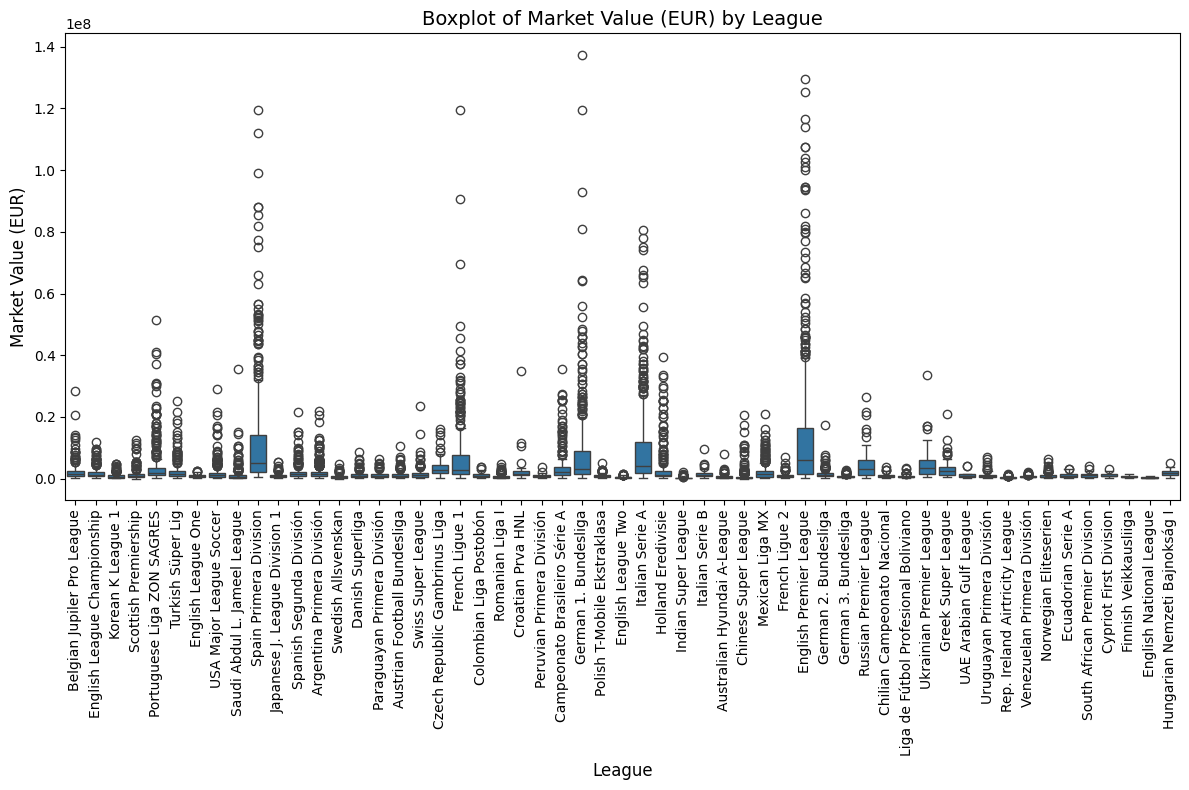

In [138]:
# Group data by 'league_name' and plot a boxplot of 'value_eur' for each league
plt.figure(figsize=(12, 8))
sns.boxplot(x='league_name', y='value_eur', data=df)

# Rotate x-axis labels for better readability if necessary
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('Boxplot of Market Value (EUR) by League', fontsize=14)
plt.xlabel('League', fontsize=12)
plt.ylabel('Market Value (EUR)', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

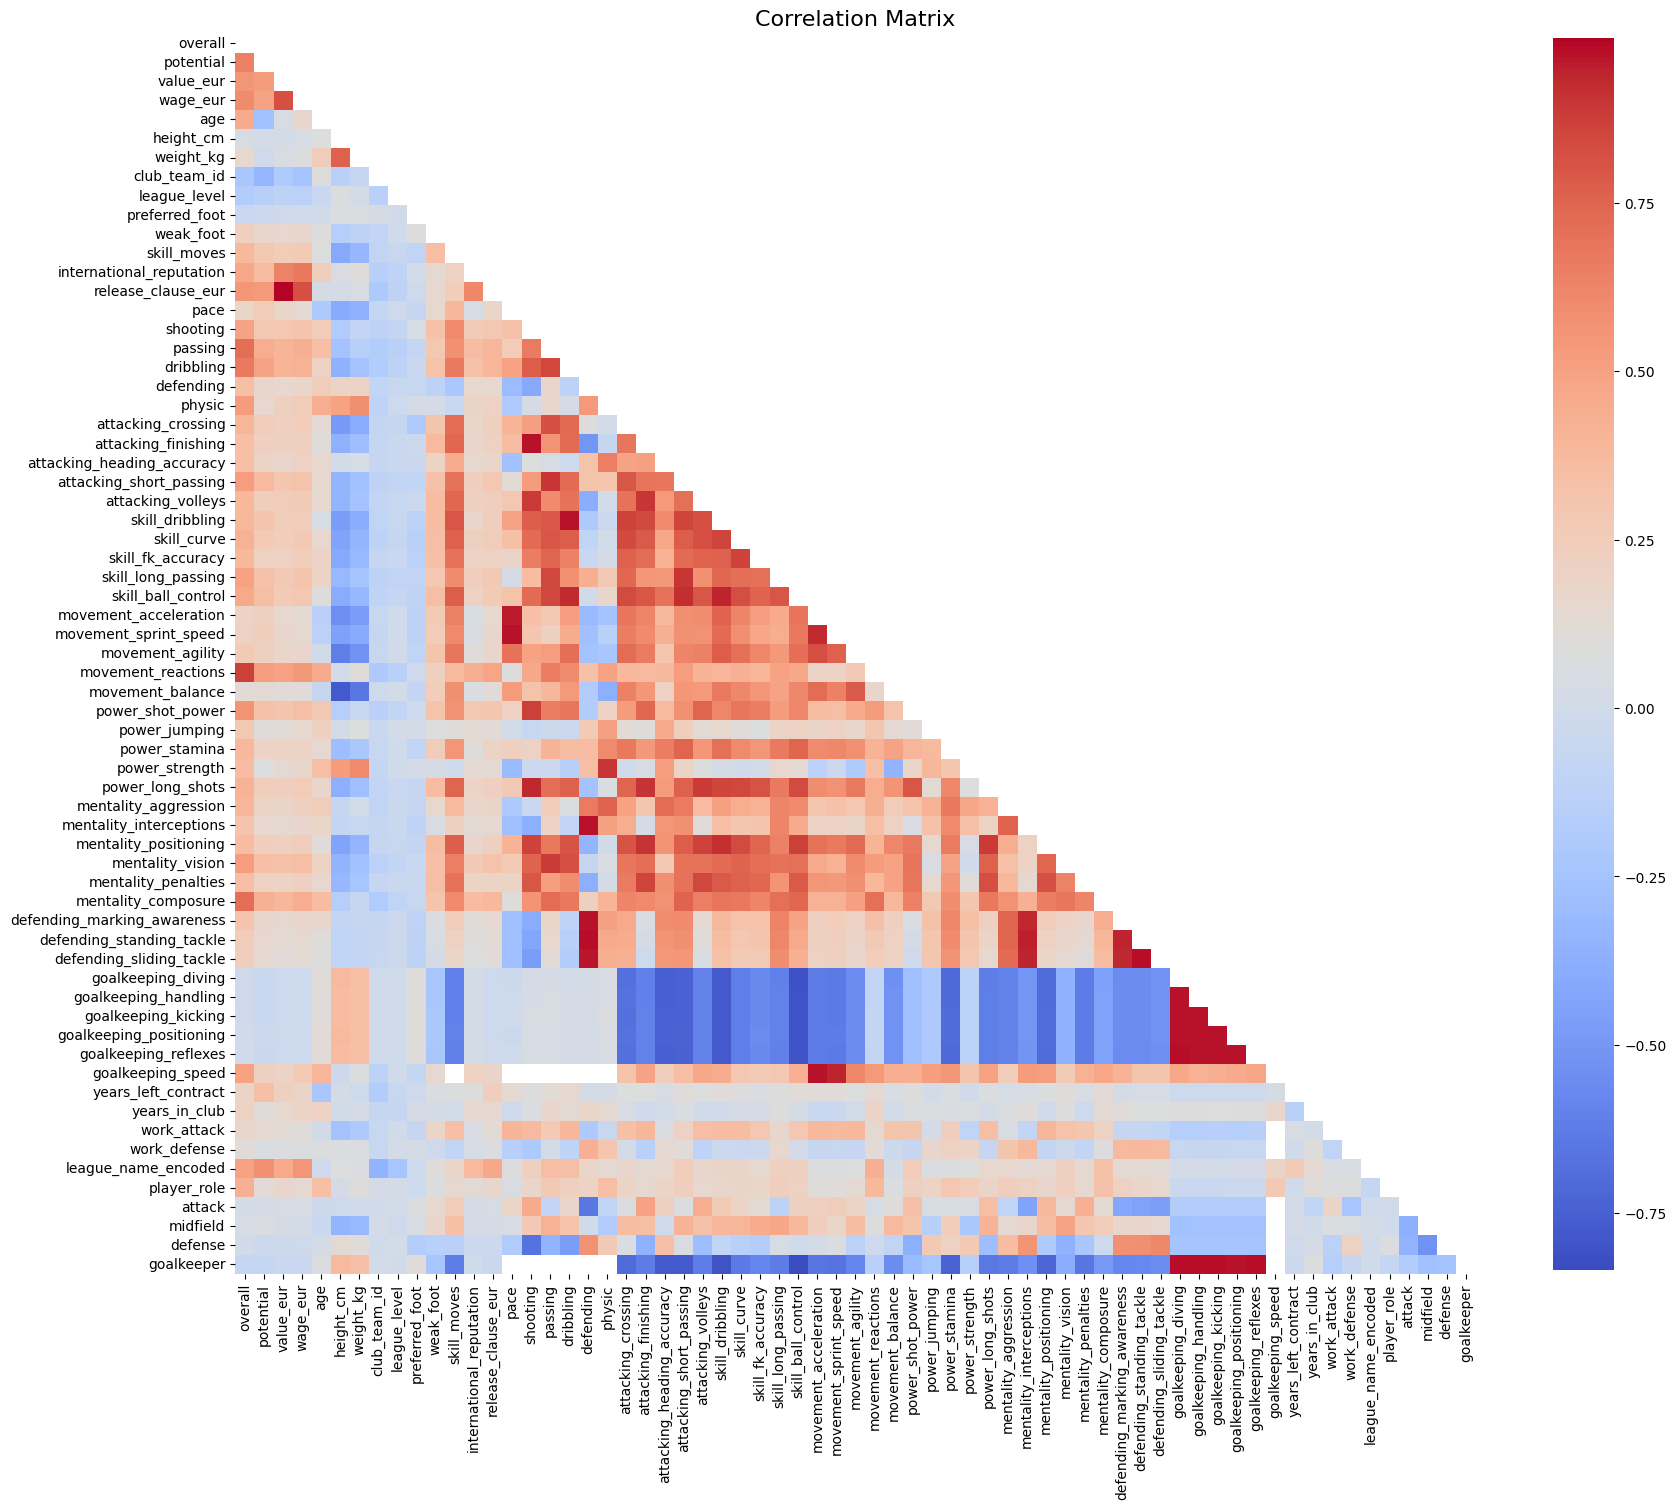

In [139]:
# correlation matrix 
plt.figure(figsize=(20, 20))
corr = df_filtered.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

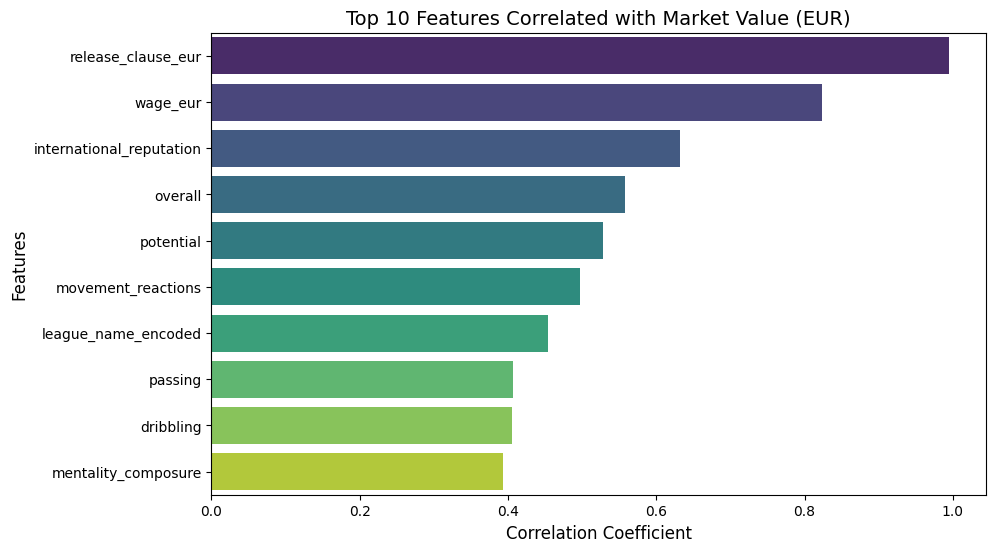

In [151]:
# TOP 10 MOST COLLERATED FEATURES 
corr_target = corr["value_eur"].abs().sort_values(ascending=False)
top_10_features = corr_target.index[1:11]  # Exclude 'value_eur' itself
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target[top_10_features], y=top_10_features, palette='viridis')
plt.title('Top 10 Features Correlated with Market Value (EUR)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

almost no correlation between the player category and the value in euro 

RMSE: 1482320.8341064479
R^2: 0.9570896031591346


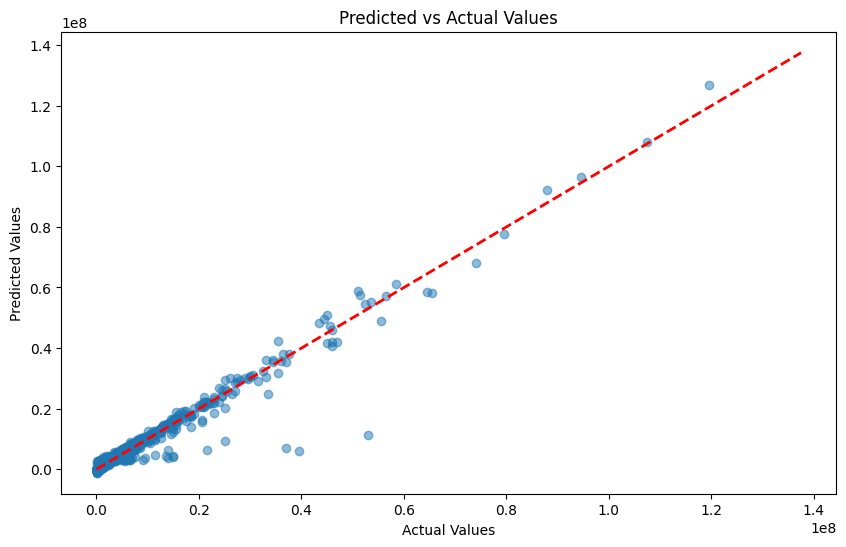

In [168]:
# BASELINE MODEL
model = LinearRegression()
X = df_filtered.drop(columns=["value_eur"]) 
y = df_filtered["value_eur"]
# impute missing values 
imputer = SimpleImputer(strategy='mean')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
model.fit(X_train_imputed, y_train)

y_pred = model.predict(X_test_imputed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

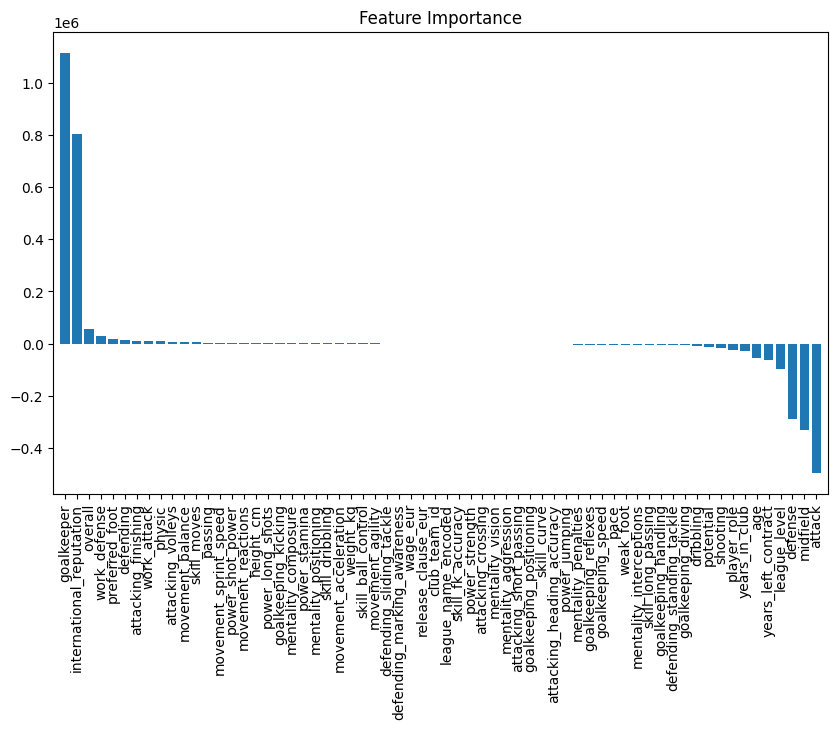

In [169]:
# feature importance 
importance = model.coef_
feature_names = X.columns
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [170]:
# NOW CONSIDER ONLY TOP 10 MOST CORRELATED FEATURES 
X_top_10 = df_filtered[top_10_features]
X_train_top_10, X_test_top_10, y_train_top_10, y_test_top_10 = train_test_split(X_top_10, y, test_size=0.2, random_state=42)
X_train_top_10_imputed = imputer.fit_transform(X_train_top_10)
X_test_top_10_imputed = imputer.transform(X_test_top_10)
model.fit(X_train_top_10_imputed, y_train_top_10)
y_pred_top_10 = model.predict(X_test_top_10_imputed)
rmse_top_10 = np.sqrt(mean_squared_error(y_test_top_10, y_pred_top_10))
r2_top_10 = r2_score(y_test_top_10, y_pred_top_10)
print(f"RMSE (Top 10 Features): {rmse_top_10}")
print(f"R^2 (Top 10 Features): {r2_top_10}")


RMSE (Top 10 Features): 1497622.7358179844
R^2 (Top 10 Features): 0.9561991080188722


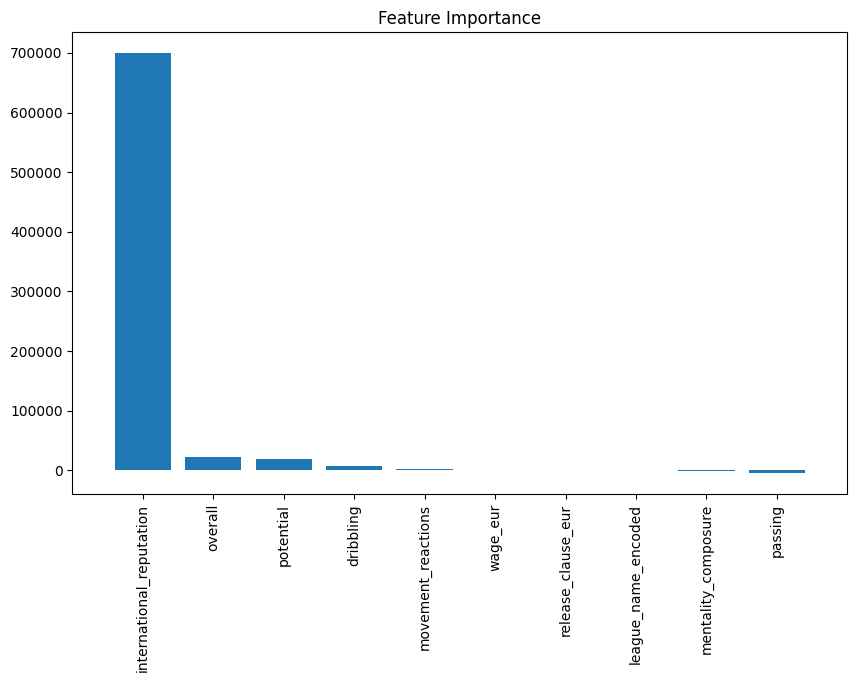

In [172]:
importance = model.coef_
feature_names = X_top_10.columns
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_top_10.shape[1]), importance[indices], align="center")
plt.xticks(range(X_top_10.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_top_10.shape[1]])
plt.show()

interesting that our linear regression model is not considering the release_clause_eur 